## Simulations For Lower-Extremity Injuries Prediction Models

In [16]:
import numpy as np
import matplotlib.pyplot as plt

### Numerical Methods

#### Euler's Method

Euler's numerical method is given by the equation: $$S(t_i+1)=S(t_i)+hF(t_i,S(t_i))$$

In [17]:
def euler(f, t, y, h):
        return y + h * f(t, y)

#### Second Order Runge-Kutta Method

The second order Runge-Kutta numerical method is given by the equations:
$$k_1=F(t_i,S(t_i))$$
$$k_2=F(t_i+h,S(t_i)+k_1)$$
$$S(t_i+1)=S(t_i)+\dfrac{1}{2}(k_1+k_2) \times h$$

In [18]:
def runge_kutta_2(f, t, y, h):
    k1 = h * f(t, y)
    k2 = h * f(t + h, y + k1)
    return y + (k1 + k2) / 2

### Simulations

#### System Dynamics Model

Model Formulation

In [19]:
def dsdt(t, s):
    #* EXAMPLE
    return np.exp(-t)

# f = lambda t, s: np.exp(-t) # ODE

# def dydt(x, y):
#     return x - y

Initial Conditions & Time Parameters

In [28]:
# Step size
h = 0.1
# Numerical grid
t = np.arange(0, 1 + h, h)
# Initial Condition
s0 = -1

##### Using Euler's Method

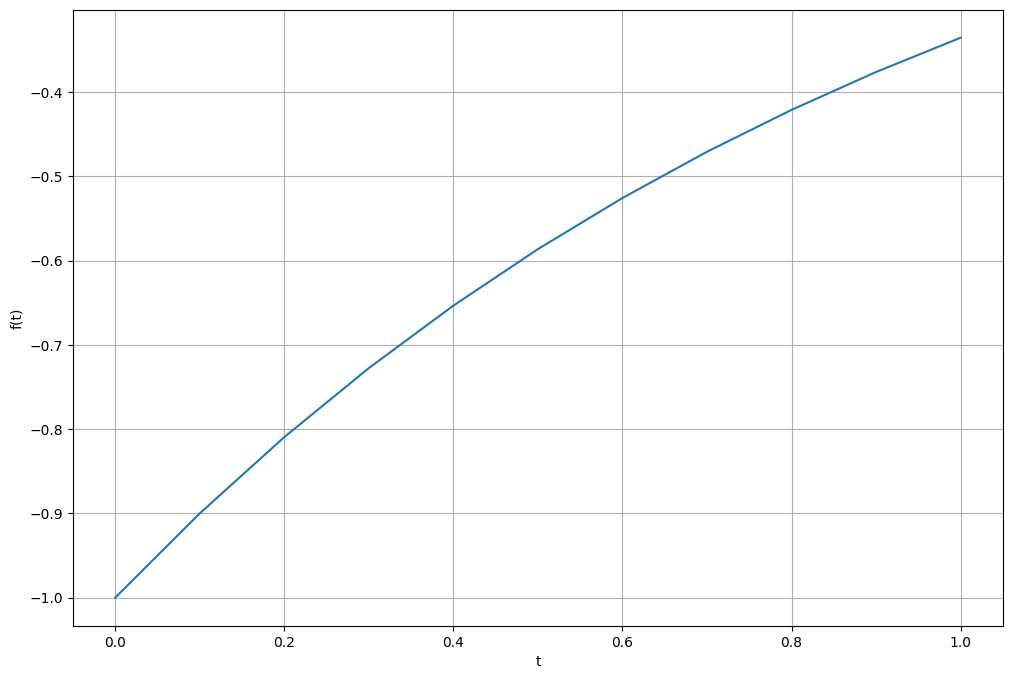

In [39]:
# Explicit Euler Method
s = np.zeros(len(t))
s[0] = s0

for i in range(0, len(t) - 1):
    s[i + 1] = euler(dsdt, t[i], s[i], h)

plt.figure(figsize = (12, 8))
plt.plot(t, s, label='Approximate')
# plt.plot(t, -np.exp(-t), 'g', label='Exact')
# plt.title('Approximate and Exact Solution \
# for Simple ODE')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.grid()
# plt.legend(loc='lower right')
plt.show()

##### Using The Second Order Runge-Kutta Method

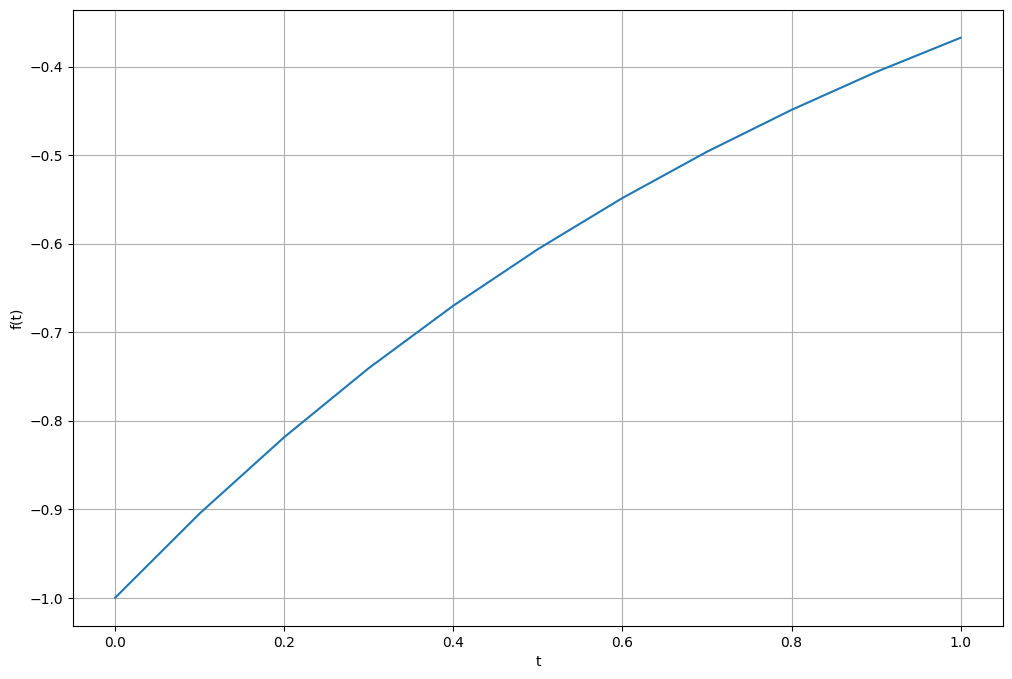

In [34]:
# Explicit Euler Method
s = np.zeros(len(t))
s[0] = s0

for i in range(0, len(t) - 1):
    s[i + 1] = runge_kutta_2(dsdt, t[i], s[i], h)

plt.figure(figsize = (12, 8))
plt.plot(t, s, label='Approximate')
# plt.plot(t, -np.exp(-t), 'g', label='Exact')
# plt.title('Approximate and Exact Solution \
# for Simple ODE')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.grid()
# plt.legend(loc='lower right')
plt.show()

#### Regression Model